# Learning differentiable policy

In [1]:
import tqdm
import torch
import confounding_robust_inference as cri

In [2]:
from matplotlib import pyplot as plt

plt.style.use("seaborn-whitegrid")
from matplotlib.cm import tab10

/tmp/ipykernel_2659112/966458967.py:2: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


In [3]:
# setup toy policy and data
_ = torch.random.manual_seed(0)
TORCH_DTYPE = cri.utils.types.get_default_torch_dtype()
beta = torch.zeros((5,), dtype=TORCH_DTYPE, requires_grad=True)
policy = cri.policies.LogisticPolicy(beta)
data = cri.data.SyntheticDataBinary()
Y_train, T_train, X_train, _, p_t_train, _ = data.sample(2000)
Y_test, T_test, X_test, _, p_t_test, _ = data.sample(2000)

## Policy Learning with KCMC Estimator (Ishikawa and Niao 2023)

In [4]:
lower_bounds_test = []
lower_bounds_train = []

In [5]:
n_iter = 300
optimizer = torch.optim.SGD(lr=0.5, params=[beta])

pbar = tqdm.tqdm(range(n_iter))
for i in pbar:

    torch.manual_seed(0)
    estimator_test = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=1.5, D=30)
    estimator_test.fit(Y_test, T_test, X_test, p_t_test, policy)
    lb_test = estimator_test.predict()
    lower_bounds_test.append(lb_test.data.numpy())

    estimator_train = cri.estimators.KCMCEstimator(const_type="Tan_box", Gamma=1.5, D=30)
    estimator_train.fit(Y_train, T_train, X_train, p_t_train, policy)
    lb_train = estimator_train.predict()
    lower_bounds_train.append(lb_train.data.numpy())

    (-lb_train).backward()
    optimizer.step()
    optimizer.zero_grad()

    pbar.set_description(f"train lower bound:\t{lb_train}\ttest lower bound\t{lb_test}")

train lower bound:	4.343570950206083	test lower bound	4.281132347233938: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [28:17<00:00,  5.66s/it]


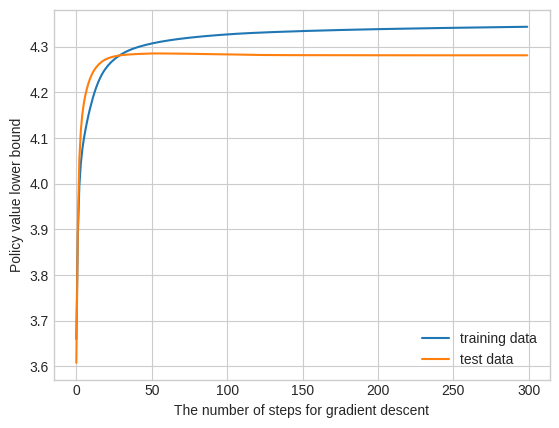

In [6]:
plt.plot(lower_bounds_train)
plt.plot(lower_bounds_test)
plt.legend(["training data", "test data"])
plt.xlabel("The number of steps for gradient descent")
plt.ylabel("Policy value lower bound")
plt.savefig("fig/differentiable_policy_learning_kcmc.pdf")

## Policy Learning with ZSB Estimator (Kallus and Zhou 2020)

In [7]:
# reset parameter
beta.data[:] = 0.0

In [8]:
lower_bounds_test = []
lower_bounds_train = []

n_iter = 300
optimizer = torch.optim.SGD(lr=0.5, params=[beta])

pbar = tqdm.tqdm(range(n_iter))
for i in pbar:

    torch.manual_seed(0)
    estimator_test = cri.estimators.ZSBEstimator(const_type="Tan_box", Gamma=1.5)
    estimator_test.fit(Y_test, T_test, X_test, p_t_test, policy)
    lb_test = estimator_test.predict()
    lower_bounds_test.append(lb_test.data.numpy())

    estimator_train = cri.estimators.ZSBEstimator(const_type="Tan_box", Gamma=1.5)
    estimator_train.fit(Y_train, T_train, X_train, p_t_train, policy)
    lb_train = estimator_train.predict()
    lower_bounds_train.append(lb_train.data.numpy())

    (-lb_train).backward()
    optimizer.step()
    optimizer.zero_grad()

    pbar.set_description(f"train lower bound:\t{lb_train}\ttest lower bound\t{lb_test}")

train lower bound:	4.274150236599044	test lower bound	4.220282718085993: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [01:56<00:00,  2.57it/s]


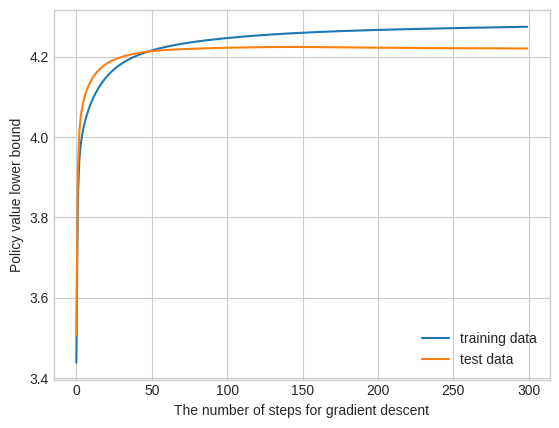

In [9]:
plt.plot(lower_bounds_train)
plt.plot(lower_bounds_test)
plt.legend(["training data", "test data"])
plt.xlabel("The number of steps for gradient descent")
plt.ylabel("Policy value lower bound")
plt.savefig("fig/differentiable_policy_learning_zsb.pdf")